In [14]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [7]:


# Specify the path to your file
file_path = 'original_data.txt'

# Read the data from the file and split it into columns using the "|"
with open(file_path, 'r', encoding='utf-8') as file:
    data = [line.strip().split('|') for line in file]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["ID", "Title", "Genre", "Description"])

# Drop the first row
df = df.iloc[1:]

# Reset the index after dropping the first row
df.reset_index(drop=True, inplace=True)



In [6]:
df

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


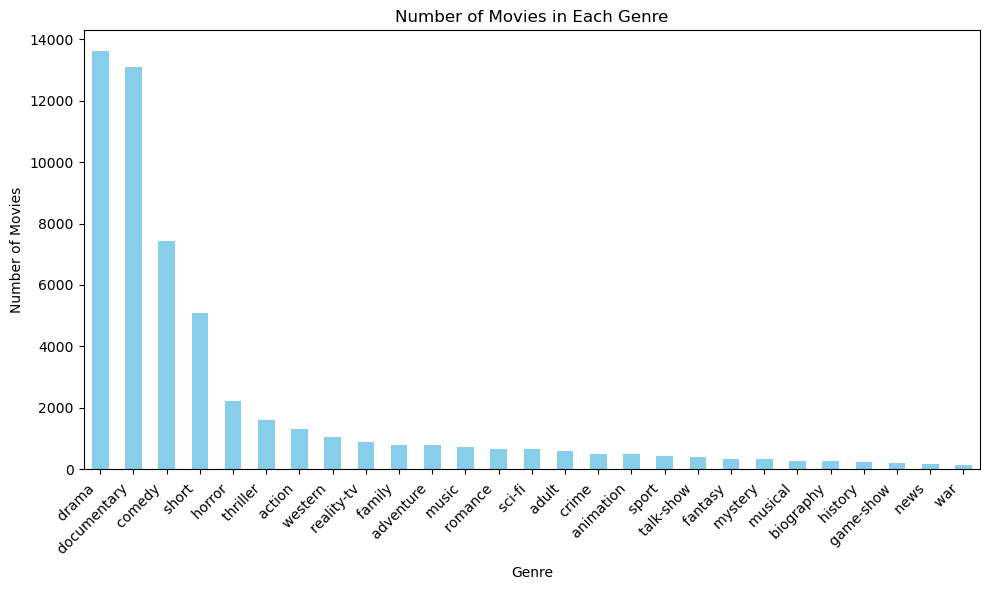

In [8]:
# Count the occurrences of each genre
genre_counts = df['Genre'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [9]:
# Create a new column 'category_id' with encoded categories based on 'Genre'
df['category_id'] = df['Genre'].factorize()[0]
category_id_df = df[['Genre', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genre']].values)

# Display the new DataFrame with the 'category_id' column
print(df.head())

# You can now use category_to_id and id_to_category dictionaries for mapping between category names and IDs


   ID                               Title       Genre  \
0  1        Oscar et la dame rose (2009)       drama    
1  2                        Cupid (1997)    thriller    
2  3    Young, Wild and Wonderful (1980)       adult    
3  4               The Secret Sin (1915)       drama    
4  5              The Unrecovered (2007)       drama    

                                         Description  category_id  
0   Listening in to a conversation between his do...            0  
1   A brother and sister with a past incestuous r...            1  
2   As the bus empties the students for their fie...            2  
3   To help their unemployed father make ends mee...            0  
4   The film's title refers not only to the un-re...            0  


In [19]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

# Transform the movie descriptions into a TF-IDF matrix
features = tfidf.fit_transform(df['Description']).toarray()

labels = df.category_id

# Display the shape of the TF-IDF matrix
print("Each of the %d movies is represented by %d features (TF-IDF score of unigrams and bigrams)" % features.shape)

Each of the 54214 movies is represented by 70972 features (TF-IDF score of unigrams and bigrams)


In [16]:
# Assuming you have already initialized features, labels, category_to_id, and tfidf as shown in the previous code

N = 3
for genre, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, df['category_id'] == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" % genre)
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))


==>  action :
  * Most Correlated Unigrams are: assassin, ninja, martial
  * Most Correlated Bigrams are: underground fight, kung fu, martial arts

==>  adult :
  * Most Correlated Unigrams are: bound, shapely, gagged
  * Most Correlated Bigrams are: binding gagging, second story, bound gagged

==>  adventure :
  * Most Correlated Unigrams are: buxom, gagged, bondage
  * Most Correlated Bigrams are: bondage vignettes, buxom brunette, bound gagged

==>  animation :
  * Most Correlated Unigrams are: adventures, bheem, animated
  * Most Correlated Bigrams are: animated series, animation series, monster high

==>  biography :
  * Most Correlated Unigrams are: 200th, smalls, parfenov
  * Most Correlated Bigrams are: thomas jefferson, american colonies, 200th anniversary

==>  comedy :
  * Most Correlated Unigrams are: sketch, hilarious, comedy
  * Most Correlated Bigrams are: romantic comedy, sketch comedy, comedy series

==>  crime :
  * Most Correlated Unigrams are: detective, police, cr

In [17]:
# Use 'Description' as the input features (X) and 'Genre' as the target labels (y)
X = df['Description']
y = df['Genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [20]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\meikf\.conda\envs\ANN2\

In [21]:
mean_accuracy = cv_df.groupby('model_name')['accuracy'].mean()
std_accuracy = cv_df.groupby('model_name')['accuracy'].std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1)
acc.columns = ['Mean Accuracy', 'Standard Deviation']

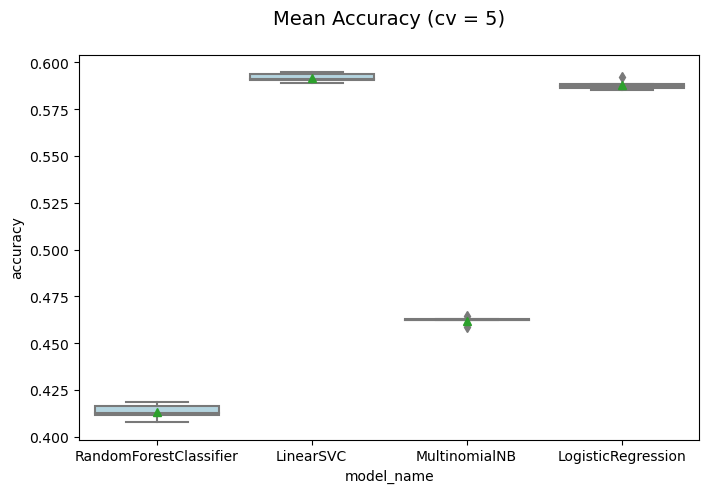

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, color='lightblue', showmeans=True)
plt.title("Mean Accuracy (cv = 5)\n", size=14)
plt.show()

In [23]:
# Use 'Description' as the input features (X) and 'Genre' as the target labels (y)
X = features
y = df['Genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Use LinearSVC as the model
model = LinearSVC()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [24]:
# Predict on the testing data
y_pred = model.predict(X_test)

# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATION METRICS



c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.40      0.28      0.33       306
       adult        0.74      0.47      0.57       163
   adventure        0.45      0.24      0.32       172
   animation        0.43      0.12      0.19       120
   biography        0.00      0.00      0.00        59
      comedy        0.53      0.60      0.56      1867
       crime        0.30      0.05      0.09       129
 documentary        0.69      0.83      0.76      3229
       drama        0.57      0.73      0.64      3503
      family        0.48      0.15      0.23       208
     fantasy        0.18      0.04      0.06        76
   game-show        0.85      0.77      0.80        43
     history        0.50      0.01      0.03        72
      horror        0.65      0.64      0.64       558
       music        0.60      0.55      0.57       153
     musical        0.29      0.03      0.05        69
     mystery        0.45      0.07      0.13        68
        n

c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


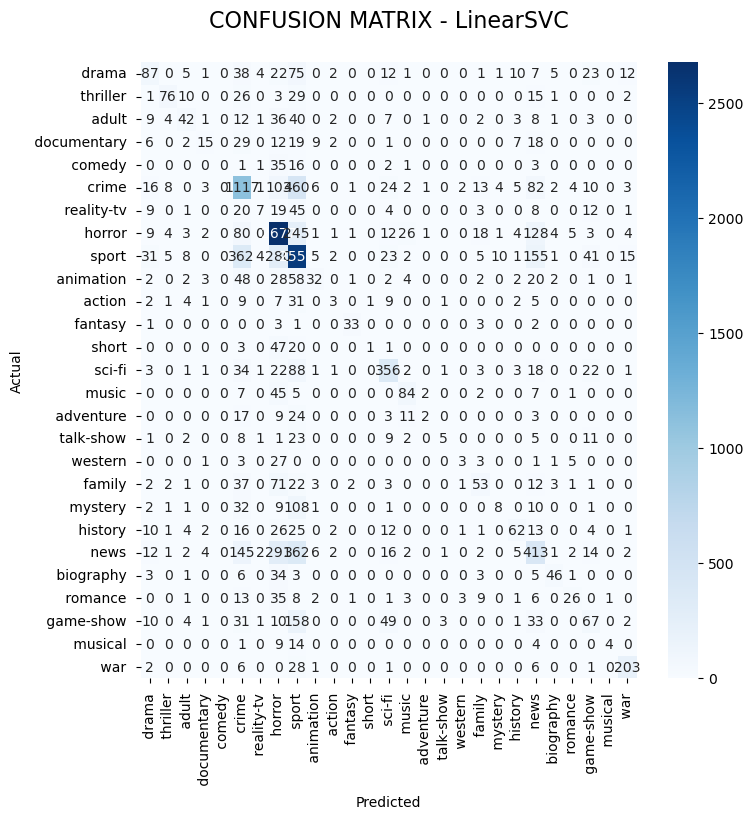

In [25]:
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=df['Genre'].unique(),
            yticklabels=df['Genre'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)
plt.show()

In [29]:
for actual in category_id_df.category_id:
    for predicted in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                                   id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))

            # Get the indices of examples where the actual category is 'actual' and the predicted category is 'predicted'
            example_indices = np.where((y_test == id_to_category[actual]) & (y_pred == id_to_category[predicted]))[0]

            # Display relevant information from the DataFrame df
            display(df.loc[example_indices][['ID', 'Title', 'Genre', 'Description']])
            print('')


' drama ' predicted as ' crime ' : 38 examples.


,ID,Title,Genre,Description
5411,5412,Vizinhos Vicini Buren Nachbarn Neighbours (20...,documentary,A documentary about the social architecture o...
5521,5522,Agapisa enan Pontio (1986),comedy,The feelings of a young lady for a Pontian Gr...
8173,8174,The Far Frontier (1948),western,Willis Newcomb and Bart Carroll head a gang e...
9081,9082,Both Ends of the Gun (????),drama,True story of two fathers' journey from murde...



' drama ' predicted as ' horror ' : 22 examples.


,ID,Title,Genre,Description
1431,1432,Nations & Tribes (2011),short,"Produced and supervised by Shahin Yazdani, 'N..."
2057,2058,"Génial, mes parents divorcent! (1991)",comedy,"Julien, a boy in the sixth grade, was badly d..."
3837,3838,Tourments d'amour (2017),drama,"On an island off the coast of Guadeloupe, two..."
4787,4788,The Human Web (2011),drama,"The Human Web, based on the hit stage play, T..."
5262,5263,Laputa (2015),drama,Johanka ('Tereza Voriskova' (qv)) spends all ...
5412,5413,Bullet for a Badman (1964),western,Murphy plays ex-lawman who must strap on the ...
5733,5734,Chicken (1996),comedy,"Dwight Serrento, once a pop-icon is now reduc..."
5744,5745,Torture Room (2007),horror,TORTURE ROOM stars Brooke Bailey and Nicki St...
6252,6253,The Greatest Fashion Icons in Film (2007),documentary,"""The Greatest Fashion Icons in Film"" will cel..."
7097,7098,From Bedrooms to Billions (2014),documentary,'From Bedrooms to Billions' is a 2 and a half...



' drama ' predicted as ' sport ' : 75 examples.


,ID,Title,Genre,Description
5339,5340,A Hollywood Scrapbook (2009),documentary,A Hollywood Scrapbook traces the film career ...



' drama ' predicted as ' game-show ' : 23 examples.


,ID,Title,Genre,Description



' thriller ' predicted as ' crime ' : 26 examples.


,ID,Title,Genre,Description
13111,13112,In Corpore (2018),drama,In Corpore is a completely improvised feature...



' thriller ' predicted as ' sport ' : 29 examples.


,ID,Title,Genre,Description



' adult ' predicted as ' horror ' : 36 examples.


,ID,Title,Genre,Description



' adult ' predicted as ' sport ' : 40 examples.


,ID,Title,Genre,Description
1193,1194,Akela (????),comedy,When an inexperienced scout leader decides to...



' documentary ' predicted as ' crime ' : 29 examples.


,ID,Title,Genre,Description



' comedy ' predicted as ' horror ' : 35 examples.


,ID,Title,Genre,Description
678,679,Pallati 176 (1986),comedy,English: A comedy by well-known Albanian thea...
786,787,Mindbenders (2004),sci-fi,Innovative surrealistic sci-fi thriller about...
2303,2304,Count It Down: Sequels Better Than the Origin...,documentary,"TVGN counts down 25 of the most memorable, ch..."
2584,2585,The Magic Legacy (2015),documentary,"A small beach tourist town in Versilia, North..."
2663,2664,Mong bat liu (2003),drama,Sui Wai lost her fiance Ah Man in a car accid...
3390,3391,"""How to Do Florida"" (2010)",adventure,Discover Florida's mysterious inner world wit...
3469,3470,I Still Love Lucy (2008),short,Follow Arlene Parness from the stages of Las ...
3847,3848,The Egan Murders (2015),documentary,"The gangland style execution of Peter, Barbar..."
4207,4208,Happiness Under No Guarantee (2009),short,Adam is a lost soul. He has lost his girlfrie...
4680,4681,Andrea Perron: House of Darkness House of Lig...,sci-fi,Growing up in the famed farmhouse investigate...



' crime ' predicted as ' horror ' : 103 examples.


,ID,Title,Genre,Description
7192,7193,Braving the Waves (2016),documentary,"This is the story of Roghieh, a woman in Sout..."
10577,10578,Le stanze aperte (2013),documentary,A documentary journalist asks for admission i...
10618,10619,"""Izingane Zobaba"" (2008)",drama,Set in world of the coal distribution industr...
11478,11479,The School for Superheroines and Other Tales ...,adventure,"Five bondage vignettes: in the first, a super..."



' crime ' predicted as ' sport ' : 460 examples.


,ID,Title,Genre,Description



' crime ' predicted as ' sci-fi ' : 24 examples.


,ID,Title,Genre,Description



' crime ' predicted as ' news ' : 82 examples.


,ID,Title,Genre,Description



' reality-tv ' predicted as ' crime ' : 20 examples.


,ID,Title,Genre,Description



' reality-tv ' predicted as ' sport ' : 45 examples.


,ID,Title,Genre,Description
8777,8778,"""Happily Never After Vlogs"" (2015)",fantasy,The evil villain is defeated and the heroine ...
10433,10434,Savitri (1937),fantasy,Unusual mythological. The love story from the...
12138,12139,Youngstown Boys (2013),documentary,"At its core, the story of Maurice Clarett and..."



' horror ' predicted as ' crime ' : 80 examples.


,ID,Title,Genre,Description
8041,8042,"""The EcoZone Project"" (2007)",reality-tv,"A series of ""green"" home makeover television ..."



' horror ' predicted as ' sport ' : 245 examples.


,ID,Title,Genre,Description



' horror ' predicted as ' music ' : 26 examples.


,ID,Title,Genre,Description
3074,3075,"""Willy Jenco"" (2018)",comedy,Willy Jenco has served his time of 23 years f...
8554,8555,Cyprien Katsaris (1979),music,The breathtaking recital given by Cyprien Kat...



' horror ' predicted as ' news ' : 128 examples.


,ID,Title,Genre,Description



' sport ' predicted as ' drama ' : 31 examples.


,ID,Title,Genre,Description
1056,1057,La terza madre (2007),horror,An ancient urn is found in a cemetery outside...
2597,2598,Reaping Rewards (2017),animation,"When faced with a difficult emotional choice,..."
11057,11058,Friday at Dewayne's (2009),comedy,"After Dewayne's parents go on a vacation, his..."



' sport ' predicted as ' crime ' : 362 examples.


,ID,Title,Genre,Description



' sport ' predicted as ' horror ' : 280 examples.


,ID,Title,Genre,Description



' sport ' predicted as ' sci-fi ' : 23 examples.


,ID,Title,Genre,Description



' sport ' predicted as ' news ' : 155 examples.


,ID,Title,Genre,Description



' sport ' predicted as ' game-show ' : 41 examples.


,ID,Title,Genre,Description



' animation ' predicted as ' crime ' : 48 examples.


,ID,Title,Genre,Description



' animation ' predicted as ' horror ' : 28 examples.


,ID,Title,Genre,Description
5385,5386,Soundproof (2009),short,"From his comfortable suburban home, a reclusi..."



' animation ' predicted as ' sport ' : 58 examples.


,ID,Title,Genre,Description



' animation ' predicted as ' news ' : 20 examples.


,ID,Title,Genre,Description



' action ' predicted as ' sport ' : 31 examples.


,ID,Title,Genre,Description
986,987,Double saut (2011),short,"Do, a 12 year-old teenager, is living in an o..."
6077,6078,Time and Place (2014),drama,When scientists reveal the universe has stopp...
8101,8102,Memories and songs (2015),documentary,In order to approach the tradition of an ethn...
11316,11317,Rhubarb and Roses (2002),short,A mother has cancer that will slowly eat her ...
13485,13486,Very Specific Things at Night (2009),short,VERY SPECIFIC THINGS AT NIGHT is a mobile pho...



' short ' predicted as ' horror ' : 47 examples.


,ID,Title,Genre,Description
1976,1977,"Die Prostitution, 1. Teil - Das gelbe Haus (1...",drama,The fates of several young girls are portraye...
2652,2653,Murder in Peyton Place (1977),mystery,Made for television movie that features some ...
2683,2684,Shakespeare's Mother: The Secret Life of a Tu...,documentary,Michael Wood tells the extraordinary story of...
3470,3471,"Sex, Lies, and Videotape (1989)",drama,"Ann is married to John, who is having an affa..."
4654,4655,The Conn Artist (2018),documentary,From his start as a presidential photographer...
5154,5155,The Insatiable Season (2007),documentary,It's January 2006 and Brian Mac Farlane's car...
5290,5291,"Luc de Heusch, une pensée sauvage (2007)",documentary,"Thanks to his questioning of the world, the e..."
5559,5560,The Man from Home (1914),drama,Wealthy brother and sister Horace and Ethel S...
7204,7205,Nativity 2: Danger in the Manger! (2012),comedy,This sequel to the popular British comedy see...
7392,7393,"""Hanzawa Naoki"" (2013)",drama,An idealistic banker takes on corruption and ...



' short ' predicted as ' sport ' : 20 examples.


,ID,Title,Genre,Description
12250,12251,Zaraza (1972),drama,Based on a true outbreak of smallpox in Wrocl...



' sci-fi ' predicted as ' crime ' : 34 examples.


,ID,Title,Genre,Description



' sci-fi ' predicted as ' horror ' : 22 examples.


,ID,Title,Genre,Description
1034,1035,Poselství Jana Palacha (2009),documentary,On the 16th of January 2009 it will be 40 yea...
2039,2040,Lost Treasures of the Ancient World: Stonehen...,documentary,This is the fascinating story of the British ...
6102,6103,Demi (2016),drama,Exploring the discrimination against bisexual...
6849,6850,Leben einen Tod lang (2004),drama,Marianne lives her life for party. When she m...
7763,7764,Tell Them We Are Rising: The Story of Black C...,documentary,"A haven for Black intellectuals, artists and ..."
8624,8625,Moonwalker (2018),documentary,Only twelve humans have ever walked on the su...
9338,9339,L'épave (1949),drama,At a show a physically strong man shoots toma...
9923,9924,Le loup blanc (1974),short,"Un homme, une femme, un chien. Un homme qui v..."
11421,11422,Brewmance (2019),documentary,Craft Beer began with a group of restless hom...
11616,11617,Nana (1934),drama,"Nana is a 1934 American Pre-Code film, produc..."



' sci-fi ' predicted as ' sport ' : 88 examples.


,ID,Title,Genre,Description



' sci-fi ' predicted as ' game-show ' : 22 examples.


,ID,Title,Genre,Description



' music ' predicted as ' horror ' : 45 examples.


,ID,Title,Genre,Description



' adventure ' predicted as ' sport ' : 24 examples.


,ID,Title,Genre,Description
12949,12950,Six Characters in Search of America (2004),documentary,Set against the backdrop of a summer barbecue...



' talk-show ' predicted as ' sport ' : 23 examples.


,ID,Title,Genre,Description



' western ' predicted as ' horror ' : 27 examples.


,ID,Title,Genre,Description
10799,10800,Lesbians Go Mad on Lesbos (2001),documentary,"During Summer 2000, the mayor of the Greek is..."



' family ' predicted as ' crime ' : 37 examples.


,ID,Title,Genre,Description



' family ' predicted as ' horror ' : 71 examples.


,ID,Title,Genre,Description
10513,10514,Teen Angst (2015),comedy,Teen Angst is an OUTtv comedy special featuri...
12444,12445,For Beauty's Sake (1941),comedy,"A woman-hating astronomy professor, Bertram D..."



' family ' predicted as ' sport ' : 22 examples.


,ID,Title,Genre,Description
1098,1099,4891 (2013),documentary,In the pre-dawn hours near a temple are the h...
7985,7986,H.O.T. Human Organ Traffic (2009),documentary,Roberto Orazi turns the camera on the lives o...



' mystery ' predicted as ' crime ' : 32 examples.


,ID,Title,Genre,Description
46,47,The End of Ageing (2010),documentary,"All over the world, human beings are living l..."



' mystery ' predicted as ' sport ' : 108 examples.


,ID,Title,Genre,Description



' history ' predicted as ' horror ' : 26 examples.


,ID,Title,Genre,Description
12247,12248,Pigs (2007),comedy,Take an intimate look at college life in the ...



' history ' predicted as ' sport ' : 25 examples.


,ID,Title,Genre,Description



' news ' predicted as ' crime ' : 145 examples.


,ID,Title,Genre,Description



' news ' predicted as ' horror ' : 291 examples.


,ID,Title,Genre,Description



' news ' predicted as ' sport ' : 362 examples.


,ID,Title,Genre,Description
1396,1397,Sky High Corral (1926),western,When the Government incorporates Bill Hayden'...



' biography ' predicted as ' horror ' : 34 examples.


,ID,Title,Genre,Description
11570,11571,Tide Marks (2004),documentary,Ten years after the triumph over Apartheid in...
13076,13077,Graphic Sexual Horror (2009),documentary,Graphic Sexual Horror takes a peek behind the...



' romance ' predicted as ' horror ' : 35 examples.


,ID,Title,Genre,Description
12595,12596,"""The Art of Acting Out"" (2015)",comedy,"Phil Collins, the barista, decides to quit hi..."



' game-show ' predicted as ' crime ' : 31 examples.


,ID,Title,Genre,Description



' game-show ' predicted as ' sport ' : 158 examples.


,ID,Title,Genre,Description



' game-show ' predicted as ' sci-fi ' : 49 examples.


,ID,Title,Genre,Description



' game-show ' predicted as ' news ' : 33 examples.


,ID,Title,Genre,Description



' war ' predicted as ' sport ' : 28 examples.


,ID,Title,Genre,Description


In [30]:
# Fit the model on the entire dataset
model.fit(features, labels)

N = 4
for genre, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[0][category_id])  # Assuming your model has only one output, adjust if needed
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(genre))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


c:\Users\meikf\.conda\envs\ANN2\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
